Test Accuracy: 0.9590
Test Precision: 0.9663
Test Recall: 0.9590
Test F1-Score: 0.9607

Detailed Classification Report:

              precision    recall  f1-score   support

      female       0.80      0.99      0.88       303
        male       1.00      0.95      0.98      1623

    accuracy                           0.96      1926
   macro avg       0.90      0.97      0.93      1926
weighted avg       0.97      0.96      0.96      1926


=== Fairness Evaluation (Per-Class Accuracy) ===
female Accuracy: 0.9868
male Accuracy: 0.9538
female FPR: 0.0462, FNR: 0.0132
male FPR: 0.0132, FNR: 0.0462


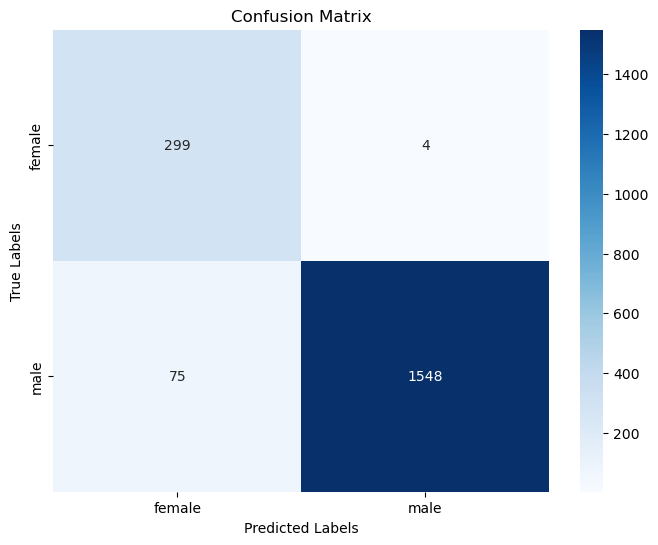


=== Generalization Assessment ===
Model accuracy when tested against shuffled labels: 0.7066
Model may be overfitting or not generalizing effectively.


In [2]:
# file: test_coatnet_gender_fairness_generalization.py

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import timm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ================================
# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ================================
# Dataset Directory
TEST_DIR = 'C:\\Users\\mrinmoy\\Desktop\\Comys_Hackathon5\\Comys_Hackathon5\\Task_A\\train'

# ================================
# Transforms
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ================================
# Dataset & DataLoader
test_dataset = datasets.ImageFolder(TEST_DIR, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

# ================================
# Model Definition
class GenderClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = timm.create_model("coatnet_0_rw_224", pretrained=False, num_classes=2)

    def forward(self, x):
        return self.model(x)

# ================================
# Load Model
model = GenderClassifier().to(DEVICE)
model.load_state_dict(torch.load("best_coatnet_gender_model.pth", map_location=torch.device('cpu')))
model.eval()

# ================================
# Evaluation
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ================================
# Metrics Calculation
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-Score: {f1:.4f}")
print("\nDetailed Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes, zero_division=0))

# ================================
# Fairness Evaluation: Per-Class Performance
print("\n=== Fairness Evaluation (Per-Class Accuracy) ===")
conf_matrix = confusion_matrix(all_labels, all_preds)
class_counts = conf_matrix.sum(axis=1)
class_correct = conf_matrix.diagonal()
per_class_accuracy = class_correct / class_counts

for idx, class_name in enumerate(test_dataset.classes):
    print(f"{class_name} Accuracy: {per_class_accuracy[idx]:.4f}")

# Calculate False Positive Rate and False Negative Rate per class
for idx, class_name in enumerate(test_dataset.classes):
    FP = conf_matrix[:, idx].sum() - conf_matrix[idx, idx]
    FN = conf_matrix[idx, :].sum() - conf_matrix[idx, idx]
    TN = conf_matrix.sum() - (FP + FN + conf_matrix[idx, idx])
    FPR = FP / (FP + TN) if (FP + TN) > 0 else 0
    FNR = FN / (FN + conf_matrix[idx, idx]) if (FN + conf_matrix[idx, idx]) > 0 else 0
    print(f"{class_name} FPR: {FPR:.4f}, FNR: {FNR:.4f}")

# ================================
# Visualization: Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# ================================
# Generalization Check: Random Label Shuffle Test
print("\n=== Generalization Assessment ===")
np.random.seed(42)
shuffled_labels = np.random.permutation(all_labels)
shuffled_accuracy = accuracy_score(shuffled_labels, all_preds)

print(f"Model accuracy when tested against shuffled labels: {shuffled_accuracy:.4f}")
if shuffled_accuracy < 0.60:
    print("Model shows good separation from random guess. Likely generalizing well.")
else:
    print("Model may be overfitting or not generalizing effectively.")

# (Optional) If you have another dataset for cross-domain testing, you can load and test it here.
